# Ground Operations Optimization – Demo Notebook

Ce notebook charge le dataset d'exemple, construit un objet `GroundOpsModel`,
et affichera ensuite les premiers résultats (une fois le modèle implémenté).


In [26]:
from pathlib import Path

import pandas as pd

from src.optimization.ground_ops_model import GroundOpsModel

# Dossier contenant les CSV
DATA_DIR = Path("data")
DATA_DIR.resolve()


WindowsPath('C:/Users/Admin/Documents/portfolio/airport-ground-ops-optimization/data')

In [27]:
# Chargement des données et création du modèle
model = GroundOpsModel.from_csv_folder(DATA_DIR)

print(f"Nombre d'avions : {len(model.aircraft)}")
print(f"Nombre de tâches : {len(model.tasks)}")
print(f"Nombre de véhicules : {len(model.vehicles)}")


Nombre d'avions : 3
Nombre de tâches : 12
Nombre de véhicules : 2


## Étape suivante : construire et résoudre le modèle

Une fois `build_model()` implémenté dans `GroundOpsModel`, tu pourras ajouter ici :

```python
model.build_model()
model.solve(time_limit=30)
solution = model.extract_solution()
```

Puis utiliser un autre notebook ou d'autres cellules pour visualiser la solution
(Gantt chart, trajectoires des véhicules, etc.).


In [28]:
from pathlib import Path
from src.optimization.ground_ops_model import GroundOpsModel

DATA_DIR = Path("data")

model = GroundOpsModel.from_csv_folder(DATA_DIR)
model.build_model()
model.solve(time_limit=10)

solution = model.extract_solution()


In [29]:
df = pd.DataFrame(solution)
df["duration"] = df["end"] - df["start"]
df.head()
df.to_csv('results/solutions/solution.csv')

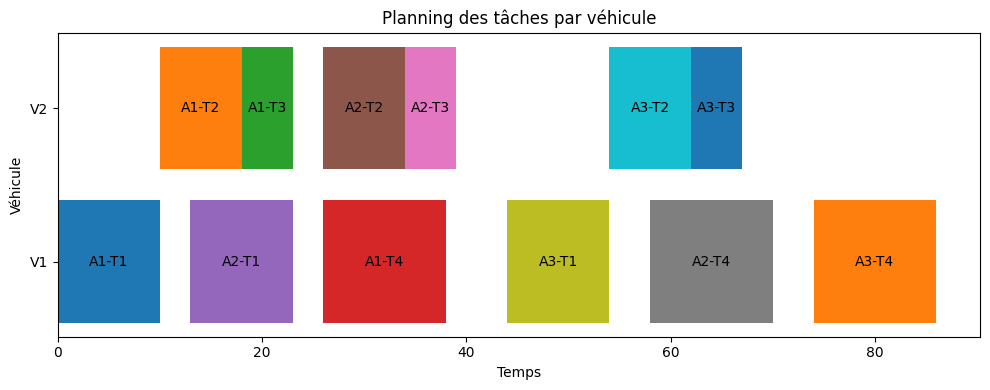

In [30]:
import matplotlib.pyplot as plt

# On ordonne les véhicules pour les afficher toujours dans le même ordre
vehicles = sorted(df["vehicle_id"].dropna().unique())
vehicle_to_y = {v: i for i, v in enumerate(vehicles)}

fig, ax = plt.subplots(figsize=(10, 4))

for _, row in df.iterrows():
    v = row["vehicle_id"]
    y = vehicle_to_y[v]
    start = row["start"]
    duration = row["duration"]

    # Bar horizontale pour chaque tâche
    ax.barh(y, duration, left=start)

    # Option : texte avec l'avion et la tâche sur la barre
    label = f"{row['aircraft_id']}-{row['task_id']}"
    ax.text(start + duration / 2, y, label, va="center", ha="center")

# Mise en forme des axes
ax.set_yticks(list(vehicle_to_y.values()))
ax.set_yticklabels(vehicles)
ax.set_xlabel("Temps")
ax.set_ylabel("Véhicule")
ax.set_title("Planning des tâches par véhicule")

plt.tight_layout()
plt.savefig("results/plots/gantt_vehicle.png")
plt.show()



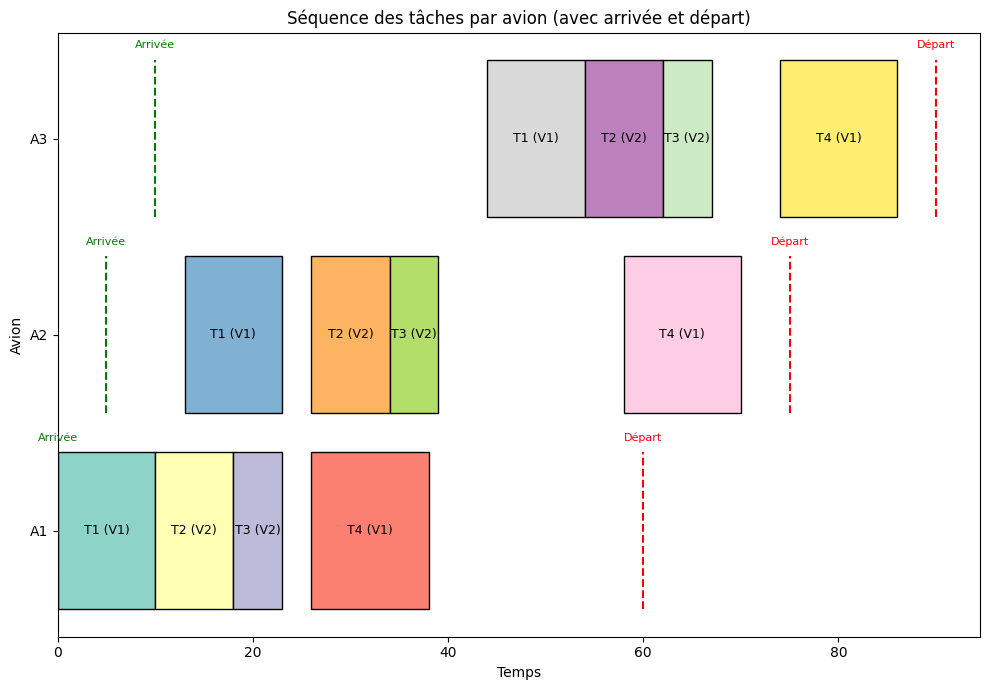

In [31]:
import matplotlib.pyplot as plt

# Avions triés pour affichage
aircrafts = sorted(df["aircraft_id"].unique())
aircraft_to_y = {a: i for i, a in enumerate(aircrafts)}

fig, ax = plt.subplots(figsize=(10, 4 + len(aircrafts)))

colors = plt.cm.Set3(range(len(df)))

# --- Barres des tâches ---
for i, (_, row) in enumerate(df.iterrows()):
    a = row["aircraft_id"]
    y = aircraft_to_y[a]
    start = row["start"]
    duration = row["duration"]

    ax.barh(
        y,
        duration,
        left=start,
        color=colors[i % len(colors)],
        edgecolor="black"
    )

    label = f"{row['task_id']} ({row['vehicle_id']})"
    ax.text(
        start + duration / 2,
        y,
        label,
        va="center",
        ha="center",
        fontsize=9
    )

# --- Ajout arrivée / départ pour chaque avion ---
for a in aircrafts:
    y = aircraft_to_y[a]
    arr = model.aircraft[a].arrival_time
    dep = model.aircraft[a].departure_time

    # Arrivée (ligne verte en pointillé)
    ax.vlines(
        arr,
        y - 0.4,
        y + 0.4,
        linestyles="dashed",
        colors="green",
        linewidth=1.5,
    )
    ax.text(
        arr,
        y + 0.45,
        "Arrivée",
        ha="center",
        va="bottom",
        fontsize=8,
        color="green",
    )

    # Départ (ligne rouge en pointillé)
    ax.vlines(
        dep,
        y - 0.4,
        y + 0.4,
        linestyles="dashed",
        colors="red",
        linewidth=1.5,
    )
    ax.text(
        dep,
        y + 0.45,
        "Départ",
        ha="center",
        va="bottom",
        fontsize=8,
        color="red",
    )

# Mise en forme
ax.set_yticks(list(aircraft_to_y.values()))
ax.set_yticklabels(aircrafts)
ax.set_xlabel("Temps")
ax.set_ylabel("Avion")
ax.set_title("Séquence des tâches par avion (avec arrivée et départ)")

plt.tight_layout()
plt.savefig("results/plots/gantt_plane.png")
plt.show()

